# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>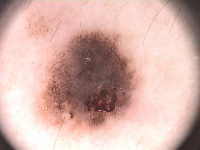</td><td>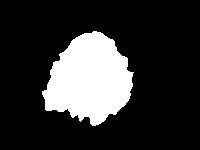</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [2]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from time import time
import random
import os
import numpy as np
from matplotlib import rcParams
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.transform import resize

In [4]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 12
seed_everything(seed)

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [5]:
images = []
lesions = []


root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

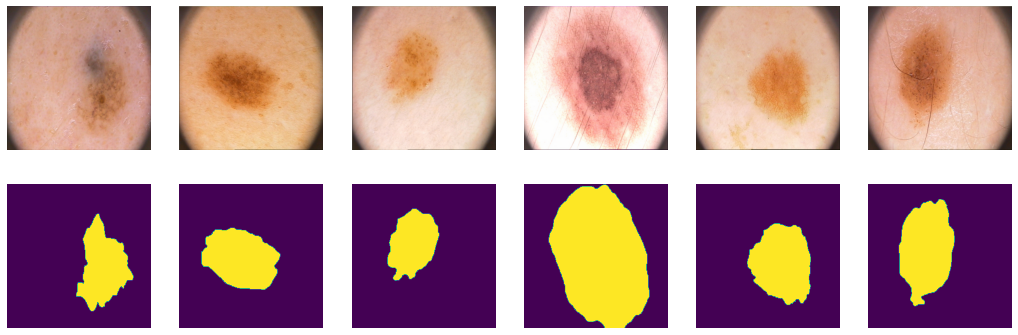

In [9]:


plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [10]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [12]:

batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [13]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

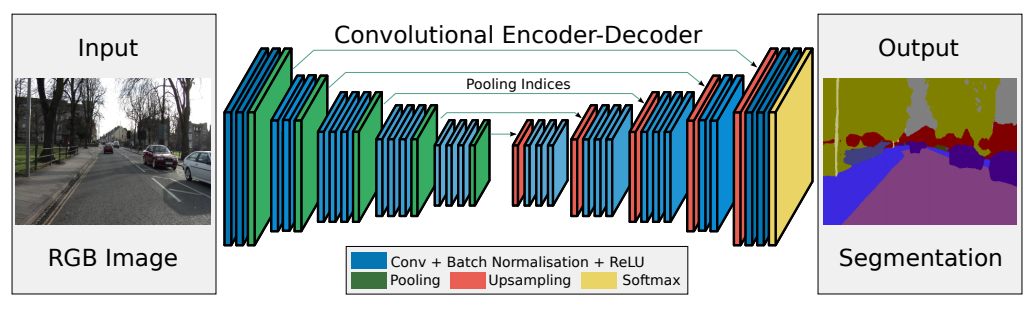

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [14]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.plot(np.arange(len(train_history)), train_history, color='red', label='train')
    #epoch_samples_num = len(train_history)/len(val_history)
    plt.plot(np.arange(len(val_history)), val_history,
             color='blue', label='val', marker='o')
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(title)
    plt.legend()
    plt.show()

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 =  nn.MaxPool2d(3, 2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))
        # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [17]:
rcParams['figure.figsize'] = (15,4)

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_real, y_pred):
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, eps=0.001, use_gc=False, scheduler=None):
    X_val, Y_val = next(iter(data_val))
    train_log = []
    val_log = []
    best_loss = float('inf')
    counter = 0
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            if use_gc:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_log.append(avg_loss)
        # show intermediate results
        model.eval()  # testing mode
        X_val = X_val.to(device)
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val)).cpu() # detach and put into cpu
        X_val = X_val.cpu()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        avg_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                # data to device
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                # set parameter gradients to zero

                # forward
                Y_pred = model(X_batch)

                loss = loss_fn(Y_batch, Y_pred)  # forward-pass

                # calculate loss to show the user
                avg_loss += loss / len(data_val)
        val_log.append(avg_loss)
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        plot_history(train_log, val_log)
        
        if best_loss - avg_loss > eps:
            counter = 0
            best_loss = avg_loss
            best_model_wts = model.state_dict()
#         else:
#             counter += 1
#         if counter > 5:
#             break
        if scheduler:
            scheduler.step()
    model.load_state_dict(best_model_wts)
    return model

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
@torch.no_grad()
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ torch.sigmoid(model(X_batch.to(device))).cpu() for X_batch, _ in data]
    return Y_pred.numpy()

In [21]:
@torch.no_grad()
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [22]:
model = SegNet().to(device)

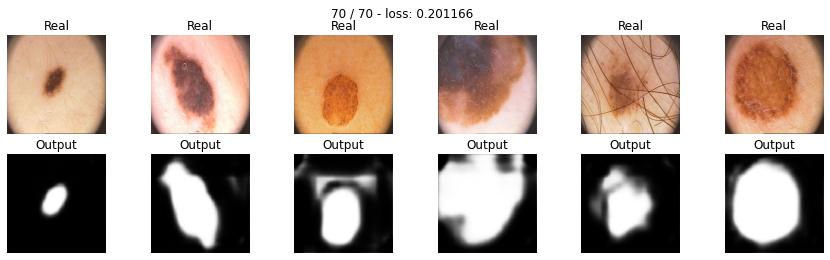

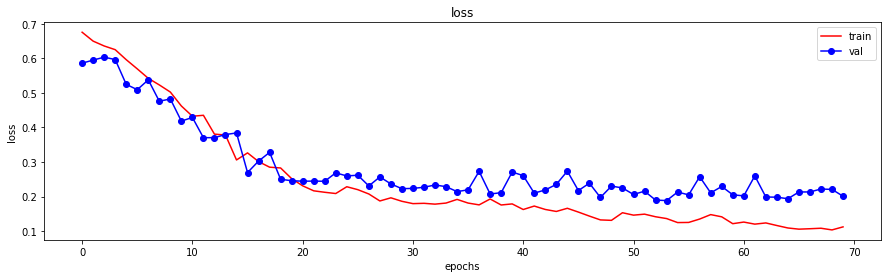

In [23]:
max_epochs = 70
optimaizer = torch.optim.Adam(model.parameters())
model = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [24]:
score_model(model, iou_pytorch,data_val)

0.671999990940094

In [25]:
score_model(model, iou_pytorch, data_tr)

0.777999997138977

In [26]:
score_model(model, iou_pytorch, data_ts)

0.7280000150203705

In [27]:
del model
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [28]:
def dice_loss(y_real, y_pred):
    eps = 1
    y_pred = F.sigmoid(y_pred)
    num = torch.mean(2 * y_pred * y_real + eps)
    den = torch.mean(y_real + y_pred + eps)
    res = 1 - (num / den)
    return res 

Проводим тестирование:

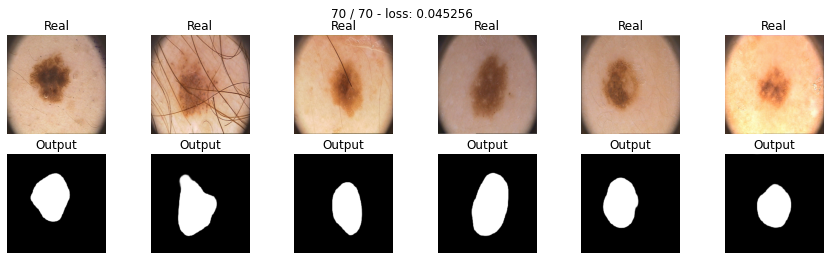

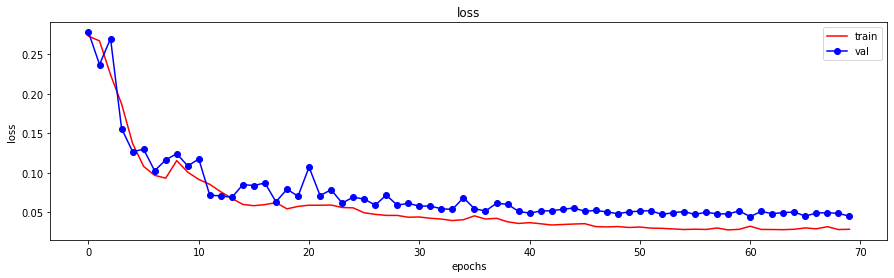

In [29]:
model_dice = SegNet().to(device)

max_epochs = 70
optimaizer = optim.Adam(model_dice.parameters())
model_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [30]:
score_model(model_dice, iou_pytorch, data_val)


0.7019999921321869

In [31]:
score_model(model_dice, iou_pytorch, data_tr)


0.7730000019073486

In [32]:
score_model(model_dice, iou_pytorch, data_ts)

0.7380000054836273

In [33]:
del model_dice
torch.cuda.empty_cache()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [34]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(F.sigmoid(y_pred), eps, 1-eps)  # hint: torch.clamp
    return -torch.mean((1-y_pred)**gamma * y_real * torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred))


In [35]:
seed = 13
seed_everything(seed)

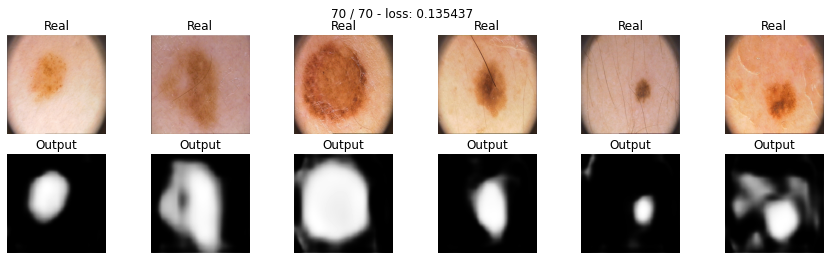

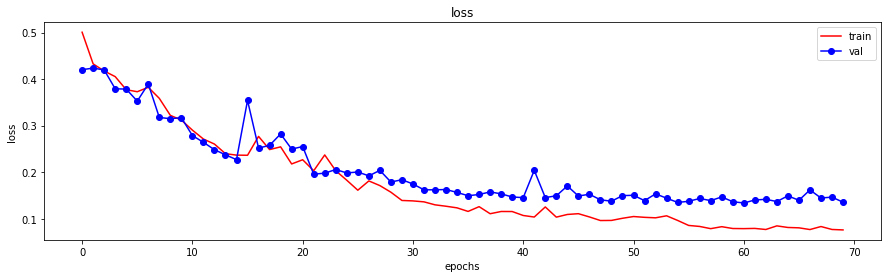

In [36]:
model_focal = SegNet().to(device)

max_epochs = 70
optimaizer = optim.Adam(model_focal.parameters())
model_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, use_gc=True)

In [37]:
score_model(model_focal, iou_pytorch, data_val)

0.6860000193119049

In [38]:
score_model(model_focal, iou_pytorch, data_tr)


0.7629999965429306

In [39]:
score_model(model_focal, iou_pytorch, data_ts)

0.7499999701976776

In [40]:
del model_focal
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [41]:
def tversky_loss(y_real, y_pred, alpha=0.7):
    eps = 0.001
    y_pred = F.sigmoid(y_pred)
    tp = torch.mean(y_pred * y_real)
    fn = torch.mean(y_pred * (1-y_real))
    fp = torch.mean((1-y_pred) * y_real)
#     print(tp.item(), fp.item(), fn.item())
    return 1 - (tp + eps)/(tp + alpha*fn + (1-alpha)*fp + eps)

In [42]:
seed = 12
seed_everything(seed)

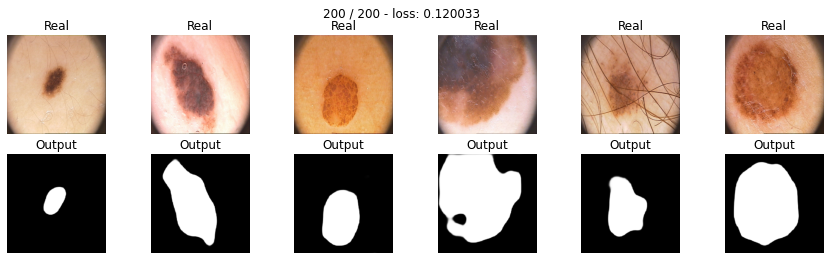

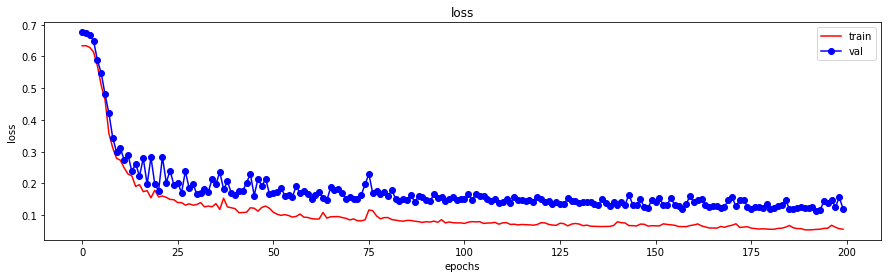

In [43]:
model_tversky = SegNet().to(device)

max_epochs = 200
optimaizer = optim.Adam(model_tversky.parameters(),lr=0.0003)
# scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=50, gamma=0.5)
model_tversky = train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [44]:
score_model(model_tversky, iou_pytorch, data_val)

0.6739999949932098

In [45]:
score_model(model_tversky, iou_pytorch, data_tr)

0.7789999842643738

In [46]:
score_model(model_tversky, iou_pytorch, data_ts)

0.7160000205039978

In [47]:
del model_tversky
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

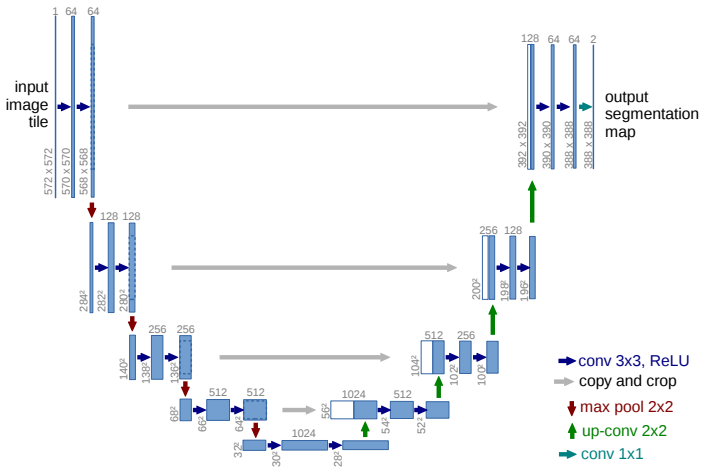

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [48]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_bn0 = nn.BatchNorm2d(64)
        self.pool0 =  nn.MaxPool2d(3, 2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, 3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(512)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(1024, 256, 3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(256)
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(512, 128, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(256, 64, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        x0 = F.relu(self.enc_bn0(self.enc_conv0(x)))
        e0 = self.pool0(x0)
        x1 = F.relu(self.enc_bn1(self.enc_conv1(e0)))
        e1 = self.pool1(x1)
        x2 = F.relu(self.enc_bn2(self.enc_conv2(e1)))
        e2 = self.pool2(x2)
        x3 = F.relu(self.enc_bn3(self.enc_conv3(e2)))
        e3 = self.pool3(x3)

        # bottleneck
        b = F.relu(self.bottleneck_bn(self.bottleneck_conv(e3)))

        # decoder
        d0 = self.upsample0(b)
        d0 = F.relu(self.dec_bn0(self.dec_conv0(torch.cat([d0,x3],dim=1))))
        d1 = self.upsample1(d0)
        d1 = F.relu(self.dec_bn1(self.dec_conv1(torch.cat([d1,x2],dim=1))))
        d2 = self.upsample2(d1)
        d2 = F.relu(self.dec_bn2(self.dec_conv2(torch.cat([d2,x1],dim=1))))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([d3,x0],dim=1))   # no activation
        return d3

In [49]:
seed = 12
seed_everything(seed)

In [50]:
unet_model = UNet().to(device)

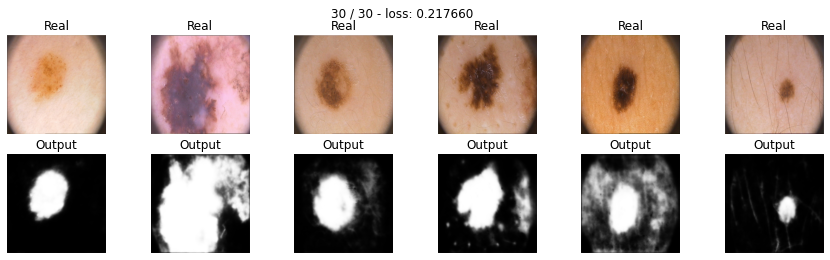

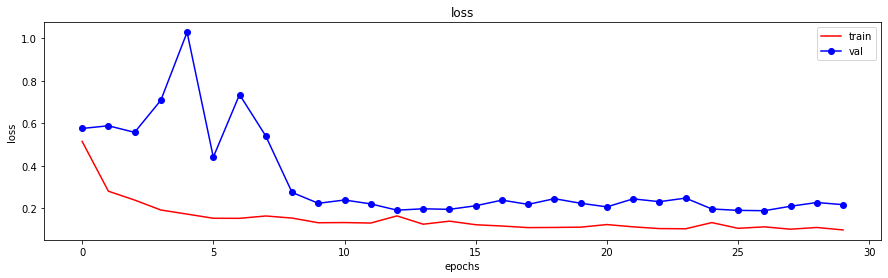

In [51]:
max_epochs = 30
optimaizer = optim.Adam(unet_model.parameters())
unet_model = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [52]:
score_model(unet_model, iou_pytorch, data_ts)

0.792000025510788

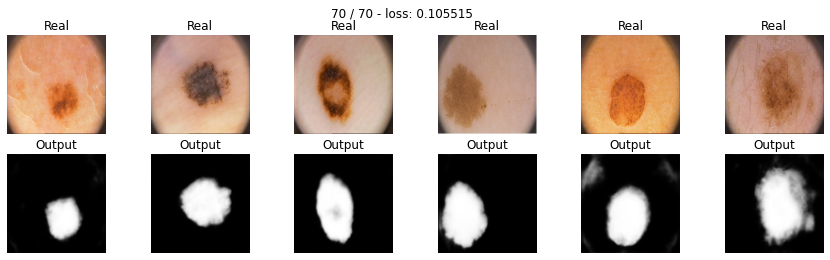

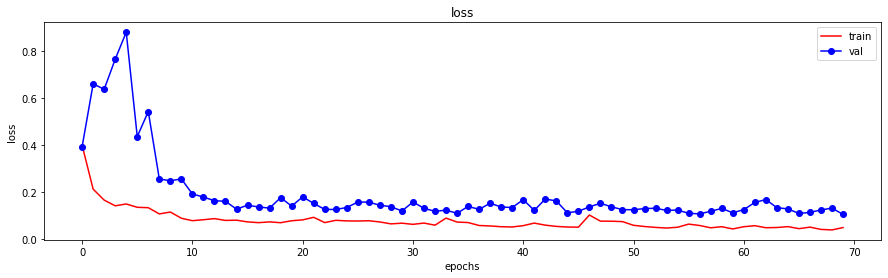

In [53]:
unet_model = UNet().to(device)
max_epochs = 70
optimaizer = optim.Adam(unet_model.parameters())
unet_model = train(unet_model, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [54]:
score_model(unet_model, iou_pytorch, data_ts)

0.7559999823570251

In [55]:
del unet_model
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [56]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_bn0 = nn.BatchNorm2d(64)
        self.pool0 =  nn.Conv2d(64, 64, 3, padding=1, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.Conv2d(128, 128, 3, padding=1, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.Conv2d(256, 256, 3, padding=1, stride=2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.Conv2d(512, 512, 3, padding=1, stride=2)  # 32 -> 16
        
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 1024, 3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(1024)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, 2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        x0 = F.relu(self.enc_bn0(self.enc_conv0(x)))
        e0 = F.relu(self.pool0(x0))
        x1 = F.relu(self.enc_bn1(self.enc_conv1(e0)))
        e1 = F.relu(self.pool1(x1))
        x2 = F.relu(self.enc_bn2(self.enc_conv2(e1)))
        e2 = F.relu(self.pool2(x2))
        x3 = F.relu(self.enc_bn3(self.enc_conv3(e2)))
        e3 = F.relu(self.pool3(x3))

        # bottleneck
        b = F.relu(self.bottleneck_bn(self.bottleneck_conv(e3)))

        # decoder
        d0 = self.upsample0(b)
        d0 = F.relu(self.dec_bn0(self.dec_conv0(torch.cat([d0,x3],dim=1))))
        d1 = self.upsample1(d0)
        d1 = F.relu(self.dec_bn1(self.dec_conv1(torch.cat([d1,x2],dim=1))))
        d2 = self.upsample2(d1)
        d2 = F.relu(self.dec_bn2(self.dec_conv2(torch.cat([d2,x1],dim=1))))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([d3,x0],dim=1))   # no activation
        return d3

In [57]:
unet2_model = UNet2().to(device)


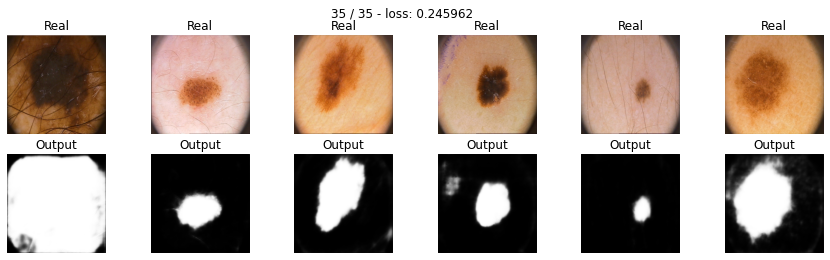

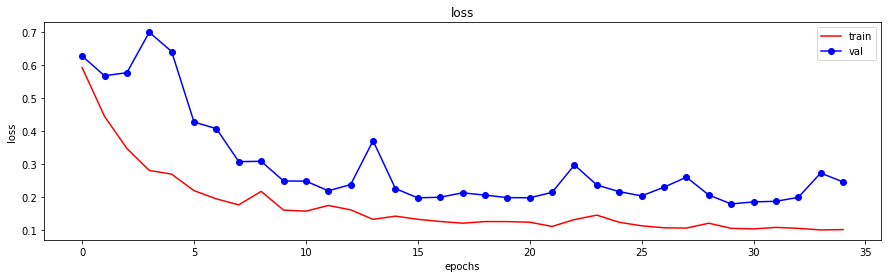

In [58]:
max_epochs = 35
optimaizer = optim.Adam(unet2_model.parameters(), lr=0.0003)
unet2_model = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [59]:
score_model(unet2_model, iou_pytorch, data_ts)

0.7440000176429749

In [60]:
seed = 15
seed_everything(seed)

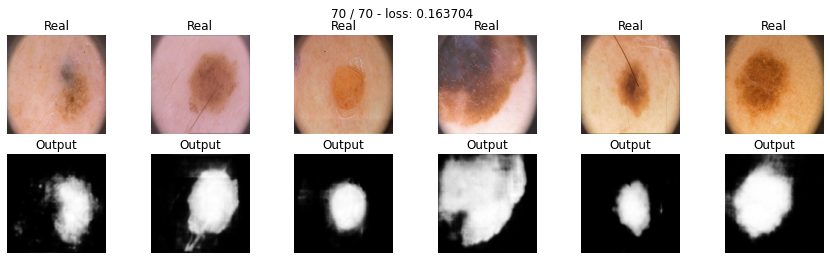

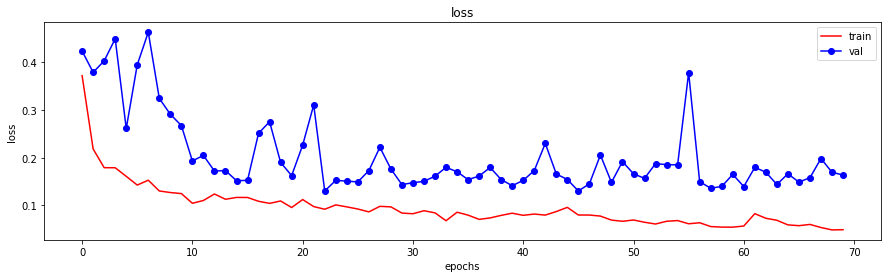

In [61]:
unet2_model = UNet2().to(device)
max_epochs = 70
optimaizer = optim.Adam(unet2_model.parameters())
unet2_model = train(unet2_model, optimaizer, focal_loss, max_epochs, data_tr, data_val, use_gc=True)

In [62]:
score_model(unet2_model, iou_pytorch, data_ts)

0.7139999866485596

In [63]:
del unet2_model
torch.cuda.empty_cache()

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [64]:
c_in = 64
padding = 0
dilation = 16
kernel_size = 3
c_in + 2*padding - dilation * (kernel_size-1) -1 +1

32

In [65]:
c_in = 32
padding = 0
dilation = 8
kernel_size = 3
c_in + 2*padding - dilation * (kernel_size-1) -1 +1

16

In [66]:
c_in = 16
padding = 0
dilation = 4
kernel_size = 3
c_in + 2*padding - dilation * (kernel_size-1) -1 +1

8

In [67]:
c_in = 16
padding = 0
dilation = 8
kernel_size = 3
c_in -1  - 2*padding + dilation * (kernel_size-1)  +1

32

In [68]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_bn0 = nn.BatchNorm2d(64)
        self.pool0 =  nn.Conv2d(64, 64, 3, padding=1, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.Conv2d(128, 128, 3, padding=1, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.Conv2d(256, 256, 3, dilation=16)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.Conv2d(512, 512, 3, dilation=8)  # 32 -> 16
        
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 1024, 3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(1024)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, 3, dilation=8) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, 3, dilation=16) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        x0 = F.relu(self.enc_bn0(self.enc_conv0(x)))
        e0 = F.relu(self.pool0(x0))
        x1 = F.relu(self.enc_bn1(self.enc_conv1(e0)))
        e1 = F.relu(self.pool1(x1))
        x2 = F.relu(self.enc_bn2(self.enc_conv2(e1)))
        e2 = F.relu(self.pool2(x2))
        x3 = F.relu(self.enc_bn3(self.enc_conv3(e2)))
        e3 = F.relu(self.pool3(x3))

        # bottleneck
        b = F.relu(self.bottleneck_bn(self.bottleneck_conv(e3)))

        # decoder
        d0 = self.upsample0(b)
        d0 = F.relu(self.dec_bn0(self.dec_conv0(torch.cat([d0,x3],dim=1))))
        d1 = self.upsample1(d0)
        d1 = F.relu(self.dec_bn1(self.dec_conv1(torch.cat([d1,x2],dim=1))))
        d2 = self.upsample2(d1)
        d2 = F.relu(self.dec_bn2(self.dec_conv2(torch.cat([d2,x1],dim=1))))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([d3,x0],dim=1))   # no activation
        return d3

In [69]:
model = DilatedUNet().to(device)

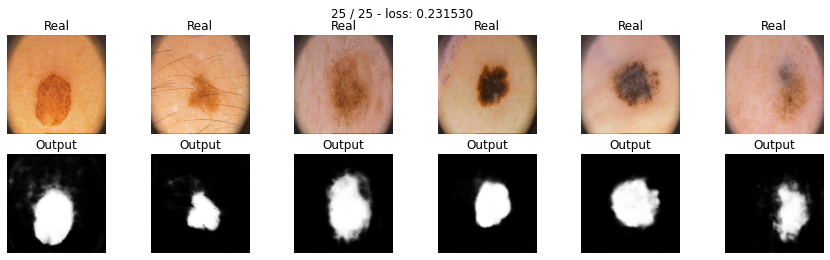

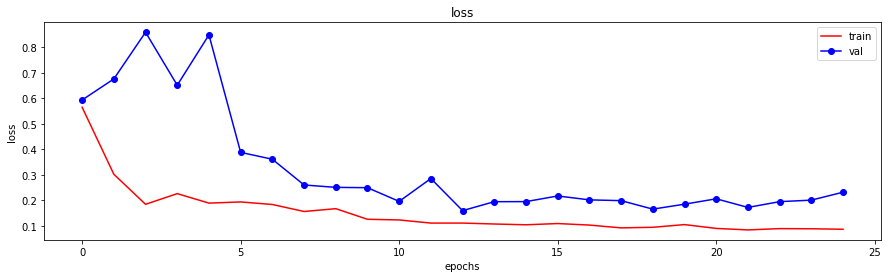

In [70]:
max_epochs = 25
optimaizer = optim.Adam(model.parameters(), lr=0.001)
model = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [71]:
score_model(model, iou_pytorch, data_ts)

0.784000039100647

In [72]:
seed = 15
seed_everything(seed)

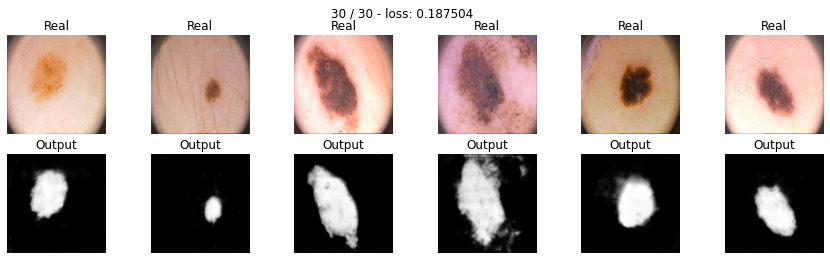

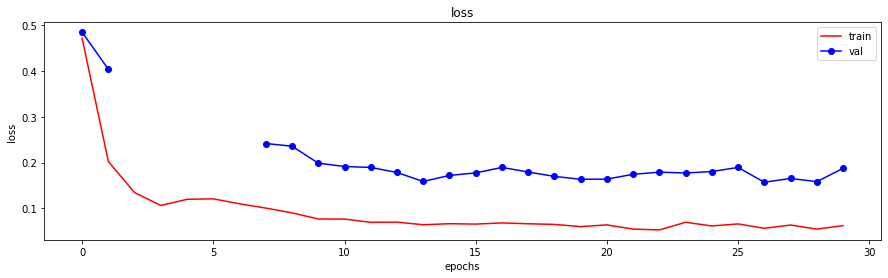

0.777999997138977

In [73]:
model = DilatedUNet().to(device)
max_epochs = 30
optimaizer = optim.Adam(model.parameters())
unet2_model = train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val, use_gc=True)

score_model(model, iou_pytorch, data_ts)

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



| Model   |Loss   | Test Score   |  
|---------|---|---|
| SegNet  | bce_loss   |0.728  |
| SegNet  | dice_loss   | 0.738  |
| SegNet  | focal_loss   | **0.749**  |
| SegNet  | tversky_loss   | 0.716 |